# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [31]:
!pip install statsmodels

import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm

## Read data 

In [32]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

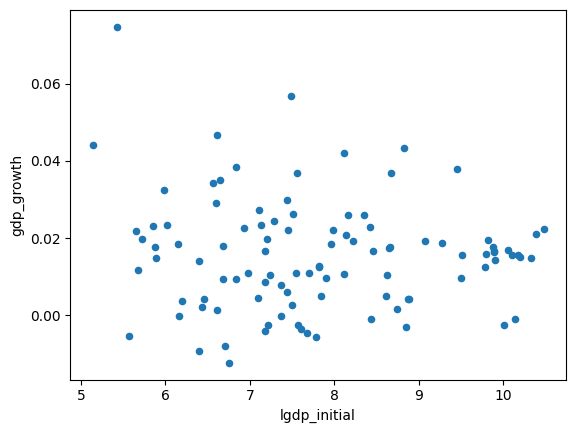

In [33]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

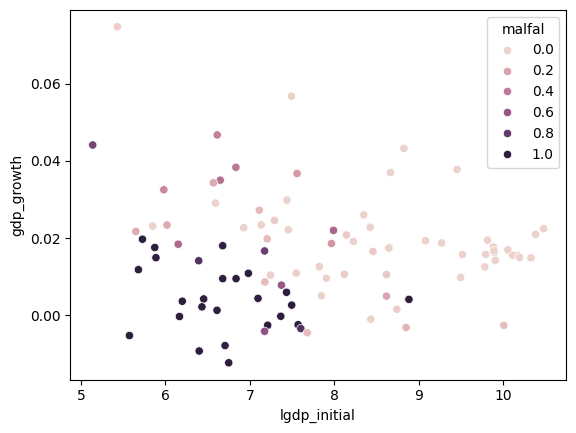

In [34]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [35]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [36]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

# Simple OLS

In [ ]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [57]:
vs = vv_all['geography'] + vv_all['religion'] + vv_all['danger'] + vv_all['resources']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# count usable observations
n_obs = I.sum()
print(f'Usable countries in this regression: {n_obs}')
# print(dat.loc[I, 'code'])

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

Usable countries in this regression: 88


In [72]:

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, xs].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[-2.79775168e-01]
 [ 1.90225857e+01]
 [ 5.69591415e-02]
 [ 8.31835365e-01]
 [-5.30653154e-04]
 [ 1.80950188e-03]
 [-1.54421759e-03]
 [ 1.01803831e+00]
 [-1.14672801e-01]
 [ 1.35355213e+00]
 [-1.19104824e+00]
 [-4.17708072e-02]
 [ 4.38440963e-01]
 [ 1.23705709e-03]
 [ 3.47342422e-08]
 [ 5.99520731e-02]
 [ 1.83816735e-02]
 [ 1.10313056e-06]
 [-1.86494932e-01]
 [ 4.62016105e-01]
 [ 9.30203577e-01]
 [ 3.97671494e-01]
 [ 8.21261614e-01]
 [ 1.48327387e+00]
 [-1.94116882e-02]
 [-1.23253561e-03]
 [-8.50581620e-03]
 [ 2.68446371e-01]
 [-2.14495017e+00]
 [ 1.15881061e-02]
 [-3.42306391e-08]
 [-2.43863387e-02]
 [-1.00572489e-01]
 [-1.24974553e-02]
 [ 3.04107362e-02]]


In [58]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.50% growth per year


,β
lgdp_initial,-1.224
pop_growth,23.417
investment_rate,0.057
tropicar,1.420
distr,-0.001
distcr,0.002
distc,-0.002
suitavg,-0.515
temp,-0.128
suitgini,-0.698


In [60]:
# compute standard deviations
sigma = X.std(axis=0)

# identify constant columns
const_idx = np.where(sigma == 0)[0]
const_vars = [xs[i] for i in const_idx]

print("Constant variables:", const_vars)

Constant variables: ['constant']


In [61]:
# keep only non-constant columns
keep_idx = np.where(sigma != 0)[0]
X = X[:, keep_idx]
xs = [xs[i] for i in keep_idx]

# re-run standardization safely
mu = X.mean(axis=0)
sigma = X.std(axis=0)
X_tilde = (X - mu) / sigma


In [62]:
def standardize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_tilde = (X - mu)/sigma
    return X_tilde

X_tilde=standardize(X)

In [63]:
X_tilde = pd.DataFrame(X_tilde)     # convert array to DataFrame
X_tilde = X_tilde.dropna()
X_tilde.isnull().sum()
X_tilde.shape
print(X_tilde)


          0         1         2         3         4         5         6   \
0   0.832768 -0.571572 -0.486127 -1.215366 -0.121426 -0.098811  0.078735   
1   1.782340 -0.401713  0.851324 -0.443370  5.130038  0.167639 -0.020707   
2   1.572371 -1.580610  0.552863 -1.274308 -1.027159 -0.713852 -0.291644   
3  -1.562169  0.717313 -2.065758  0.901564  1.117055  2.263429  1.915688   
4   1.581014 -1.575866  0.155999 -1.274308 -1.061052 -0.845393 -0.703803   
..       ...       ...       ...       ...       ...       ...       ...   
83  0.670803 -1.505683 -0.954193 -1.274308 -0.808411 -0.584022 -0.549269   
84  1.696279 -0.936920 -0.132950 -1.271011  0.418400  0.459765  1.183136   
85  0.740908  0.187575 -0.097737 -1.192159  0.105147  0.014014 -0.132012   
86 -0.258748  1.276106  2.355974  0.901564  0.317149  2.207531  1.886001   
87 -0.398205  0.285719 -1.340638  0.901564 -0.450803  0.599409  0.557154   

          7         8         9   ...        25        26        27        28  \
0   0.

In [81]:
# BCCH pilot penalty
n,p = X.shape
c = 1.1
alpha = 0.05
yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_pilot: ', round(penalty_pilot, 2))

# Pilot estimates
#Create predicted value using Lasso 
pred = Lasso(alpha=penalty_pilot).fit(X_tilde,y).predict(X_tilde)

# Alternative: Manually
coeff_pilot = Lasso(alpha=penalty_pilot).fit(X_tilde,y).coef_
coef_intercept = Lasso(alpha=penalty_pilot).fit(X_tilde,y).intercept_
pred = (coef_intercept + X_tilde@coeff_pilot)

# Updated penalty
eps = y - pred 
epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)
print('Penalty BCCH: ', round(penalty_BCCH, 2))

# Updated estimates
fit_BCCH = Lasso(alpha=penalty_BCCH).fit(X_tilde,y)
coeff_BCCH = fit_BCCH.coef_
print('Coefficients: ', np.round(coeff_BCCH))

# Selected variables
selected_variables_BCCH = (coeff_BCCH != 0)
print('Selected variables: ', Xnames[selected_variables_BCCH].to_list())

Penalty_pilot:  1.12


ValueError: Data must be 1-dimensional, got ndarray of shape (88, 88) instead